# Practical 6. Modelling differentiation between pairs of populations


At the end of this practical you should:

- Know how to estimate differentiation between populations/species using $d_{xy}$, $d_a$ and $F_{ST}$ and understand how these summary statistics are defined and related to each other.
- Be able to relate estimates of divergence and differentiation obtained from whole genome data to models of equilibrium population structure and non-equilibrium population history.
- Be able to define outliers of differentiation in a genome scan.
- Be able to simulate sequence data under models of population structure and compare these to real data.

## 6.1. Import data

In [1]:
import msprime
import tskit
import numpy as np
import pandas as pd
import allel
import seaborn as sns
sns.set_theme(style="whitegrid")
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
#jupyter magic
%matplotlib inline
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

We will import a variant only vcf file containing variation data for several individual samples of *Heliconius* butterflies belonging to different closely related species and mimicry races. To keep things manageable, we will focus on a single chromosome (18) in the practical.

These data were obtained by mapping WGS Illumina reads against the *Heliconius melpomene* reference genome are from [(Martin et al 2020)](https://datadryad.org/stash/dataset/doi:10.5061/dryad.sk2pd88). The feature as an example dataset in a seminal review of speciation genomics which discusses the limitations of genome scans [(Seehausen 2014, Fig 1)](https://www.nature.com/articles/nrg3644).

As in practical 4, we will use the `allel` function `read_vcf`. Because the vfc has been filtered, we only need to read in GTs, positions and samples: 

In [3]:
query_fields = ['samples', 'calldata/GT', 'variants/CHROM', 'variants/POS', 'variants/is_snp']

In [7]:
! wget  https://www.dropbox.com/s/w5r4y848t8vrcnb/p6_data.tar.gz?dl=0 -q --show-progress -O p6_data.tar.gz
! tar zxf p6_data.tar.gz

p6_data.tar.gz      100%[===================>]  21.86M  28.5MB/s    in 0.8s    


In [4]:
vcf_f ='p6_data/heli_chrom18.vcf.gz'
helidata = allel.read_vcf(vcf_f, fields = query_fields)

It is convenient to store the GT data as an array (see practical 4). Let's save this as `heliGTs`.

In [15]:
heliGTs = allel.GenotypeArray(helidata['calldata/GT']);
heliGTs

<GenotypeArray shape=(1441823, 52, 2) dtype=int8>
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/1 ... 0/1 0/0 ./. 0/0 0/0
...
0/0 ./. 0/0 0/0 0/0 ... ./. 0/0 0/0 0/0 0/0
0/0 ./. 0/0 0/0 0/0 ... ./. 0/0 0/1 0/0 0/0
0/0 ./. 0/0 0/0 0/0 ... ./. 0/1 0/1 0/0 0/0

<div class="alert alert-block alert-success">    
<b>Exercise 1:</b> How many variants are in this file? Are they all SNPs?
        
<b>Hint:</b> We have done these checks in practical 4.
     </div>

In [ ]:
#SOL

<div class="alert alert-block alert-success">
<b>Exercise 2:</b> How many samples does the vcf include? What is their ploidy? 
    </div>

In [ ]:
#SOL

It might useful to look up the `pyvcf` methods for Genotype Arrays:

In [16]:
print(dir(heliGTs))

['__abs__', '__add__', '__and__', '__array__', '__class__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__inv__', '__invert__', '__iter__', '__le__', '__len__', '__lshift__', '__lt__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__reduce__', '__reduce_ex__', '__repr__', '__rshift__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '__xor__', '_is_phased', '_mask', '_repr_html_', '_values', 'caption', 'compress', 'concatenate', 'copy', 'count_alleles', 'count_alleles_subpops', 'count_call', 'count_called', 'count_het', 'count_hom', 'count_hom_alt', 'count_hom_ref', 'count_missing', 'display', 'displayall', 'fill_masked', 'from_packed', 'from_sparse', 'get_display_items', 'haploidify_samples', 'i

The dataset includes samples from each of the following 5 taxa:

- *H. melpomene malleti* (mal)
- *H. melpomene rosina* (ros)
- *H. melpomene amaryllis* (ama)
- *H. timareta florencia* (flo)
- *H. cydno* (cyd)

The dataset also includes two samples for an outgroup: *H. numata*  (nu_sil).

Let's assign the names of the samples included in `helidata` to a new variable `samples`:

In [17]:
samples = helidata['samples']
print(samples)

['ros.CAM1841' 'ros.CAM1880' 'ros.CAM2045' 'ros.CAM2059' 'ros.CAM2519'
 'ros.CAM2552' 'ros.CJ2071' 'ros.CJ531' 'ros.CJ533' 'ros.CJ546'
 'mal.CS1002' 'mal.CS1011' 'mal.CS1815' 'mal.CS21' 'mal.CS22' 'mal.CS24'
 'mal.CS586' 'mal.CS594' 'mal.CS604' 'mal.CS615' 'ama.JM160' 'ama.JM216'
 'ama.JM293' 'ama.JM48' 'ama.MJ11-3188' 'ama.MJ11-3189' 'ama.MJ11-3202'
 'ama.MJ12-3217' 'ama.MJ12-3258' 'ama.MJ12-3301' 'chi.CAM25091'
 'chi.CAM25137' 'chi.CAM580' 'chi.CAM582' 'chi.CAM585' 'chi.CAM586'
 'chi.CJ553' 'chi.CJ560' 'chi.CJ564' 'chi.CJ565' 'flo.CS12' 'flo.CS13'
 'flo.CS14' 'flo.CS15' 'flo.CS2337' 'flo.CS2338' 'flo.CS2341' 'flo.CS2350'
 'flo.CS2358' 'flo.CS2359' 'nu_sil.MJ09-4125' 'nu_sil.MJ09-4184']


<div class="alert alert-block alert-success">
<b>Exercise 3:</b>
    
- What is the position of the first and last variant on chromosome 18? 
- Define the position of the last variant as the length of the chromosome and assign this to a variable `chrom18Len`.
    </div>

In [ ]:
#SOL

## 6.2 Recap - organizing info into dataframes, measuring individual genetic diversity

### 6.2.1 How does genetic diversity vary between *Heliconius* taxa?

The name of the taxon is indicated by the first three letters of the sample name. Let's define a dataframe that contains the taxon labels as a separate column. We first use `split('.')` to separate the sample name string at `'.'` and store the first element of each sample name in a list we've named `specieslabel`. 

In [18]:
specieslabel = [samplename.split('.')[0] for samplename in samples]

Let's define a new dataframe `samples_df` which contains `samples` and the list `specieslabel` as separate columns:

In [19]:
samples_df = pd.DataFrame({'samples':samples, 'taxon':specieslabel})
samples_df.head()

,samples,taxon
0,ros.CAM1841,ros
1,ros.CAM1880,ros
2,ros.CAM2045,ros
3,ros.CAM2059,ros
4,ros.CAM2519,ros


<div class="alert alert-block alert-warning">
    <b>Python reminder: <code>for</code> loops</b>
    
To compute the heterozygosity for each sample, let's set up an empty array and use a <code>for</code> loop to record the heterozygosity of each sample and print the per individual heterozygosity:
</div>

In [20]:
het_array = np.zeros(len(samples))
for i in range(len(samples)):
    het_array[i] = heliGTs[:,i].count_het()/chrom18Len

<div class="alert alert-block alert-success">
<b>Exercise 4:</b>

Add the estimates of heterozygosity in `het_array` to the dataframe `samples_df` and plot the mean heterozygosity within all six taxa. 

Which taxon has the highest heterozygosity?

How does mean heterozygosity compare to estimates for other insects [(see Figure 1 in Leffler et al)](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1001388")?

**Hint:** [seaborn barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html) is a useful way to visualize this; but other visualisations are possible.
        </div>

In [ ]:
#SOL

<div class="alert alert-block alert-warning">
    <b>Python: </b>
<code>groupby</code> is a very handy method when summarising information in dataframes. E.g. this gives the maximum heterozygosity in each taxon as a pivot table:
</div>

In [ ]:
het_df = samples_df.groupby('taxon').mean()
het_df

### 6.2.2 How does genetic diversity vary along chromosome 18?

Given that we are interested in computing genetic diversity within and divergence between taxa, it is helpful to subset the GT array by taxon.

For example, if we are interested in the *Heliconius malleti* samples (named after the biologist [James Mallet](https://g.co/kgs/Y1zDhT)), we first generate a list of indices for the `mal` samples. We can then use these indices as an argument in `.count_alleles`. Setting `max_allele =1` guarantees that GTs involving more than two alleles (aka multiallelic sites) are excluded:

In [20]:
mal = samples_df[samples_df.taxon == 'mal'].index;
mal_counts = heliGTs.count_alleles(subpop = mal, max_allele=1)

<div class="alert alert-block alert-success">
<b>Exercise 5:</b>

Use the `allel` function [`sequence diversity`](https://scikit-allel.readthedocs.io/en/stable/stats/diversity.html) to estimate pairwise genetic diversity per site (Tajimas's $\pi$) in *H. malleti*.
</div>

In [ ]:
#SOL

<div class="alert alert-block alert-success">
<b>Exercise 6:</b>
    
- Estimate genetic diversity in 50kb windows. Use `sns.lineplot`to plot diversity along chromsome 18.
- Use `sns.distplot` to plot the distribution of window-wise diversity estimates. What could explain the shape of the distribution of $\pi$ at the scale of 50kb?

**Hint:** Check practical 4 for how we did this using the function `windowed_diversity`. Adding the window-wise $\pi$ estimates (stored in`pi_mal_wins`) to a new dataframe and including a new column for the central position of each window.
</div>

In [ ]:
#SOL

## 6.3. Divergence and differentiation in one focal pair of *Heliconius* butterflies

### 6.3.1  Some *Heliconius* background

If we focus on *H. malleti*, we can make four pairwise comparisons with other taxa. These are (in order of increasing distance):

        malleti vs amaryllis         A very close sympatric pair with different twing patterns
        malleti vs rosina            Equivalent to the above but allopatric
        malleti vs florencina        Sympatric species that look identical but are very diverged genetically
        malleti vs cydno             Allopatric species, even more divergent.

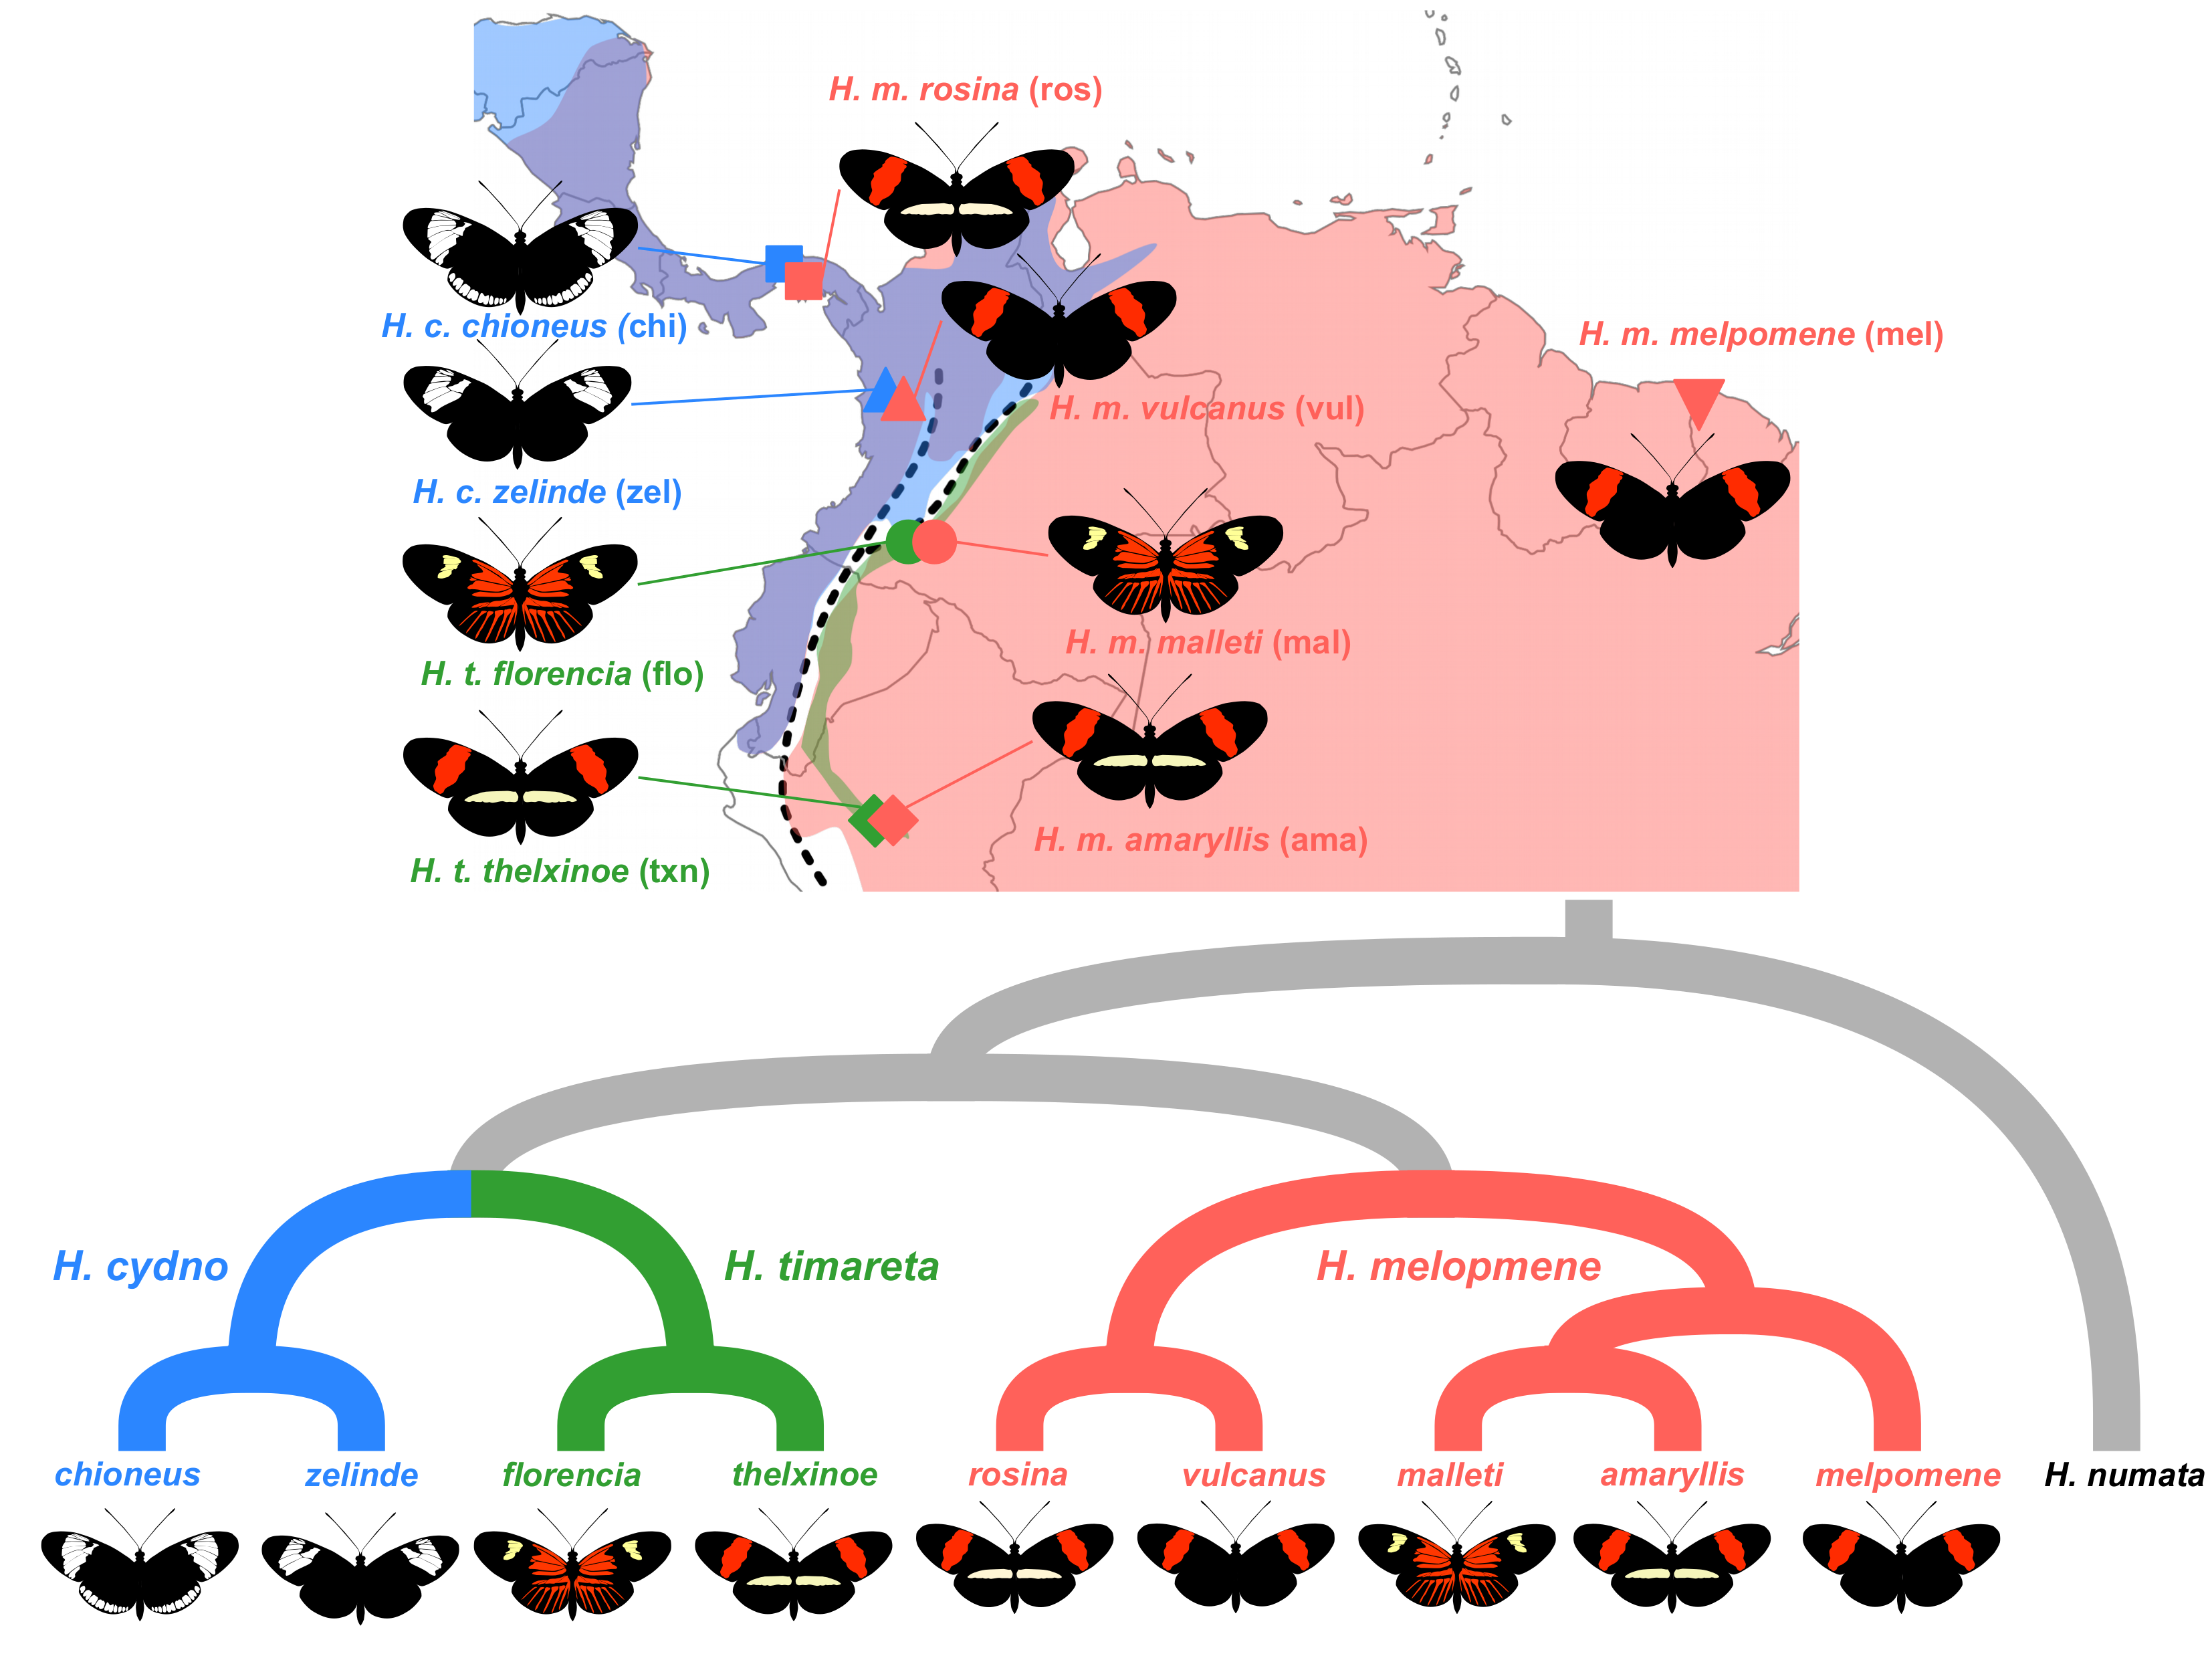

For this part of the practical you will first draw one of the other taxa at random and compare its divergence at chromosome 18 to *H. malletti*. Execute the cell below once and record the output in a markdown cell!

In [ ]:
non_mal_taxa = ['rosina','amaryllis', 'florencia', 'cydno']
np.random.choice(non_mal_taxa)

<div class="alert alert-block alert-success">
<b>Exercise 7:</b>

- Compute $\pi$ for the other taxon in your pair.
- How do the two species compare in terms of genetic diversity? How does $\pi$ differ from mean heterozygosity in *H. malletti* and your Heliconius taxon?
</div>

In [ ]:
#We have already computed the mean heterozygosity for all taxa:
het_ama= het_df['heterozygosity']['ama']
#You could measure the difference between pi and H formally using the fixation index F_IS = 1 - (H/pi)

### 6.3.2 Divergence

<div class="alert alert-block alert-success">
    <b>Exercise 8:</b>

- Use the function [`sequence_divergence`](https://scikit-allel.readthedocs.io/en/stable/stats/diversity.html) to compute $d_{xy}$ (per base) between *H. maletti* and your taxon. How does this compare to the mean genetic diversity within species?
- Use $d_{xy}$ and $\pi$ estimates for your focal taxon pair to compute the net divergence $d_a$ (assume that the ancestral $N_e$ is the average of the $N_e$ of the two taxa).
- Use $d_a$ to estimate the divergence time ($T$) between the taxa under a model of simple species split (see lecture 6). What simplifyimg assumptions does this calcualtion make? How might the estimate of $T$ be biased/wrong?


**Hint:** Assume a mutation rate of $\mu =2.9 * 10^{-9}$ per base and generation [(Keightley et al 2013)](https://academic.oup.com/mbe/article/32/1/239/2925597) and 6 generations per year.
</div>

In [33]:
#SOL

### 6.3.3 Measuring differentiation using $F_{st}$

<div class="alert alert-block alert-success">
<b>Exercise 9:</b> Use your estimate of $d_{xy}$ and mean $\pi$ between your two taxa to calculate $F_{ST}$.
    </div>

In [32]:
#SOL

<div class="alert alert-block alert-success">
<b>Exercise 10:</b> Let's assume that the data were generated under an equilibrium model of symmetric migration. In this case, we can use Wright's result for the expected $F_{ST}$ to estimate the scaled migration rate, i.e. the number of migrants $M =  4N_e m$.

**Hint**: See lecture 6
</div>

In [73]:
#SOL
print("Assuming equilibrium migration, Fst implies", ((1/fst_mal_ama )-1)/8, "migrants per generation")

Assuming equilibrium migration, Fst implies 2.8749444978964007 migrants per generation


<div class="alert alert-block alert-success">
<b>Exercise 11:</b> 

- Estimate diversity for the other taxon in your pair in 50kb windows and add these estimates to the dataframe `window_stats` you have defined previously. 
- Plot window-wise diversity of BOTH taxa along the chromosome. Are there any obvious patterns?
- Are there any regions in which the two taxa have very different $\pi$?
</div>

In [34]:
#SOL

In [35]:
#SOL
fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(window_stats["coordinates"], window_stats["pi_mal"], label='H. malleti diversity in 50 kb windows')
sns.lineplot(window_stats["coordinates"], window_stats["pi_ama"], label='H. amaryllis diversity in 50 kb windows')
plt.xlabel('Mb')
plt.ylabel('pairwise diversity')
plt.show()

<div class="alert alert-block alert-success">    
<b>Exercise 12:</b> 

The functions `windowed_divergence` and `windowed_patterson_fst` have analogous syntax to `windowed_diversity`. Estimate $d_{XY}$ and $F_{st}$ between <i>H. malleti</i> and your focal taxon in 50kb windows and add these estimates to the `window_stats` dataframe.

- Plot $F_{ST}$ along chromosome 18 and include a line defining the 5% of windows with highest $F_{st}$
- Is optix an $F_{ST}$ outlier at the 5% level?
- Do you expect your two taxa to be fixed for different alleles at optix given their wing patterns?
- Check the SweepFinder scan for chromosome 18 in *H. malleti* at the end of practical 5 (exercise 13). What, if any is the overlap between sweep and $F_{ST}$ outliers?
    
**Hint:** You can use the code below to define the  95\% quantile of $F_{ST}$ and `plt.axhline(y=quantile95_fst, alpha=0.5, color ='r')` to include a horizontal line in your $F_{st}$ scan. Similarly, use `plt.axvline(x= pos, linewidth=20, alpha=0.6)` to define a vertical line at some position `pos`.
</div>

In [37]:
#SOL

In [78]:
quantile95_fst = window_stats["fst"].quantile(.95);
print(quantile95_fst)

0.2569731405600356


The gene *optix* is situated at the beginning ($\approx 1Mb$) of chromosome 18 encodes red wing patterns on the fore and hind wings (see [Jiggins et al 2017](https://royalsocietypublishing.org/doi/full/10.1098/rstb.2015.0485))
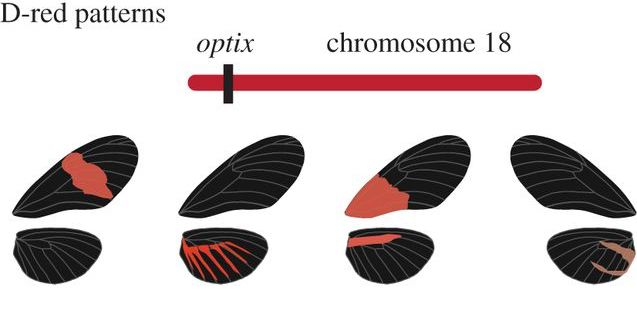. The coordinates of optix are:

In [79]:
optix_pos = np.array([1058778, 1159581])

In [ ]:
#SOL
#Define the position of optix:
optix = optix_pos.mean()*1e-6
#Useful code for adding lines to your plot
plt.axhline(y = quantile95_fst, alpha=1, color ='r')
plt.axvline(x = optix, linewidth=10, alpha=0.4, color ='r')

<div class="alert alert-block alert-success">    
    <b>Exercise 13:</b> Are outliers in $F_{ST}$ on chromsome 18 driven by reduced $\pi$ or increased $d_{xy}$ or both? Plot mean $\pi$ against $d_{xy}$ and highlight the 5% outliers.

**Hint**: It may be easiest to add a column indicating $F_{st}$ outliers to the dataframe (see practical 4 for an example of how to do this using <code>np.where()</code>). For plotting <a href = "https://seaborn.pydata.org/generated/seaborn.scatterplot.html"> <code>sns.scatterplot</code></a> does the trick!
</div>

In [38]:
#SOL

<div class="alert alert-block alert-success">    
<b>Exercise 14:</b>

- Given your estimates of $T$ under a history of divergence and your estimate of inferred $N_e$, simulate a dataset of the same size as chromosome 18, consisting of 50kb windows. 
- How well does the observed distribution of $F_{st}$ fit the simulated distribution (use `sns.histplot` to plot both distributions together)?
- How well does the real data fit the simulated data? 
- Name two proccesses you could add to your simulation to improve the fit.
</div>

We will ignore linkage between windows, i.e. each window in the real data is a simulation replicate:

In [39]:
#SOL

The code chunk below sets up a simulation for a history of divergence between two species. For more info on the syntax see [`msprime`](https://tskit.dev/msprime/docs/stable/demography.html). 

The values are arbitrary. You need to adjust these according to the estimates for your taxon pair 

In [85]:
# add the relevant parameters to the divergence simulation
sample_size = 

#Rates for migration, recombination and mutation are unscaled and per generation:
sequence_length =
recr = 1.84675e-8

demography = msprime.Demography()
demography.add_population(name="Hmal", initial_size=Ne)
demography.add_population(name="Hama", initial_size= Ne)
demography.add_population(name="ancestor", initial_size= Ne)
demography.add_population_split(time = t_div, derived=["Hmal", "Hama"], ancestral="ancestor")
replicates = msprime.sim_ancestry(samples={"Hmal": sample_size, "Hama" : sample_size}, 
                          sequence_length = sequence_length, recombination_rate=recr, random_seed = 123,
                          demography=demography, num_replicates = num_windows)

In [86]:
#SOL
mu = 
sim_Fst = np.zeros(num_windows)
sim_div = np.zeros(num_windows)
sim_piA = np.zeros(num_windows)
sim_piB = np.zeros(num_windows)
for replicate_index, ts in enumerate(replicates):
    A = ts.samples()[0:20]
    B = ts.samples()[20:40]
    ts_muts = msprime.sim_mutations(ts, rate=mu, random_seed=5678)
    sim_Fst[replicate_index] = ts_muts.Fst(sample_sets=[A, B])
    sim_div[replicate_index] = ts_muts.divergence(sample_sets=[A, B])
    sim_piA[replicate_index] = ts_muts.diversity(A)
    sim_piB[replicate_index] = ts_muts.diversity(B)

Once you have an array of simulated $F_{st}$ values `sim_Fst`, you can use the code below to plot both simulated and real distributions of Fst (and related summaries): 

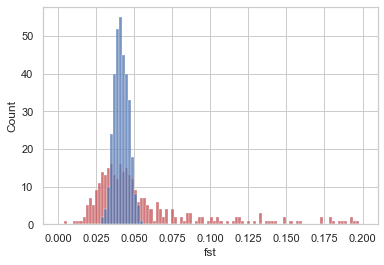

In [88]:
sns.histplot(window_stats["fst"], color= 'r', binwidth = 0.002, binrange = [0,0.2])
sns.histplot(sim_Fst, color= 'b', binwidth = 0.002, binrange = [0,0.2])
plt.show()